# Atmospheric Model Intercomparison Project (AMIP) Validation

To investigate global stilling, we want to force the models realistic historical SST forcing in order to force the models with the observed realization. To do this we use the `amip-hist` model runs.

__Variables analyzed__
<!-- - `uas`: eastward wind component (usually 10 m) [$m \ s^{-1}$]
- `vas`: northward wind component (usually 10 m) [$m \ s^{-1}$] -->
- `sfcWind`: Near-Surface Wind Speed [$m \ s^{-1}$]
- _sfcWind anomaly_: artificially constructed according to $x_i-\bar{x}_{\text{time}}$

11 models are available on Andromeda (The BC Cluster) at `/data/projects/bccg/CMIP6/amip-hist/mon/uas` and `/data/projects/bccg/CMIP6/amip-hist/mon/vas` respectively. Models are at _monthly_ resolution and aggregated _yearly_ before any trend analysis is analyzed.
<!--
__Steps to connect to BC Cluster__
1. Install Remote SSH and Remote X11 extensions in VScode
2. `ssh -Y username@andromeda.bc.edu`
3. Enter password
4. You are now in your home directory located at `~/mmfs1/data/_username_`
5. `module load python/3.9.0` $\leftarrow$ add to .tcshrc file 

__To start an interactive session__:

`interactive -t [DD-hh:mm] [-N nodes) [-n tasks] [-c cpus-per-task] [-m gb] [-p partition] [-G #] [-X] [-h]`

Options:  
- `t`: Wall Time (default is 4 hours)
- `N`: Number of nodes (default is 1) 
- `m`: GB of Memory per node (default is 4GB) 
- `n`: Number of tasks per node (default is 1) 
- `c`: Number of cpu cores per task (default is 4) 
- `X`: Use X11 
- `p` <partition name>: Use the partition specified (default is shared) 
- `G` #: Specify the number of GPUs per gpu node
- `h`: help

My default command: `interactive -n 5 -m 10GB`

Useful command to monitor usage: `htop`

__Getting Conda up and Running__
1. `module load anaconda/2023.07-p3.11`
2. `conda init tcsh`
3. `conda create -n _envname_ python=3.11`
4. `conda activate _envname_`

This will create a conda environment in the `/mmfs1/data/_username_/.conda/envs/_envname_` directory. To automatically use this environment on login use add `conda activate _envname_` to your `.tcshrc` file.

__For a faster environment solver__
1. `conda install -n _envname_ conda-libmamba-solver`
2. `conda config --set solver libmamba`

__Export Environment__: `conda env export --no_builds > environment.yml`

__Note__: To use `matplotlib` we must install $\LaTeX$. Jupyter Notebooks use MathJax under the hood which is why we only need to install if it using $\LaTeX$ in python.
-->

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import nc_time_axis
import numpy as np
import polars as pl
import pandas as pd
import pwlf
import xarray as xr
import cf_xarray as cfxr
import regionmask
from glob import glob
import os
import dask
import scienceplots
%matplotlib inline
plt.style.use(["nature", "notebook"])

xr.set_options(keep_attrs=True)
%load_ext rich
from rich import print  # pretty printing
from tqdm import tqdm  # progress bar
import warnings  # deal with warnings

# from importlib import reload

# Playing nice with CMIP6
# from xmip.preprocessing import combined_preprocessing
from xclim.ensembles import create_ensemble, ensemble_mean_std_max_min

## Helper Functions

In [2]:
def mask_data(data, map, regions: None, drop=False, reverse=False):
    """Mask xarray data based on region names

    Args:
        data (xarray dataset): xarray dataset to mask
        map (regionmask): regionmask object
        regions (list or None): list of region names to mask. if None, all regions are taken. Defaults to None.
        drop (bool, optional): Whether to drop when masking. Defaults to False.
        reverse (bool, optional): Whether to mask the inverse of the regions. Defaults to False.

    Returns:
        xarray dataset: masked dataset
    """
    # Load the region mask
    mask = map.mask(data.cf['X'], data.cf['Y'])
    # Extract keys for the region
    id_dict = map.region_ids
    # Get region names
    if regions is None:
        names = id_dict.keys()
    else:
        # Coerce region names to uppercase
        regions = [region.upper() for region in regions]
        names = [name for name in id_dict.keys() if str(name).upper() in regions]
        assert len(names) == len(regions), 'Not enough regions found'
    # Get the key for the regions
    keys = [id_dict[name] for name in names]
    # Apply the mask to the data
    if reverse:
        masked_data = data.where(~mask.isin(keys), drop=drop)
    else:
        masked_data = data.where(mask.isin(keys), drop=drop)
    return masked_data

## CMIP vs AMIP
- Using AMIP models (prescribed SSTs) to check against observational data
- Observation is only realization of the state, so use the prescribed SST to capture that single state.
- Pull in 7 amip-hist datasets, download and analyze
- Model is fundamentally flawed if AMIP doesn't capture multi-decadal trend

## Create the ensemble

In [6]:
# Get all model names
model_folders = glob('/Volumes/valencig@bc/data/sfcWind/*')
model_names = [f.split('/')[-1] for f in model_folders]
# Remove 'FGOALS-g3' as it has negative wind speeds for some reason
model_names.remove('FGOALS-g3')
n_models = len(model_names)
print(f'{n_models} models found...')
print('Model names:')
print(model_names)
# Create list to hold datasets
ensemble = dict()
# Create dictionary to display indices of models
realizations_dict = dict()
with warnings.catch_warnings():  # suppress warnings from xarray bookeeping
    warnings.simplefilter("ignore")
    for model in tqdm(model_names, desc='Loading models'):
        # Sort to make sure realization indices increasing
        paths = sorted(glob(f'/Volumes/valencig@bc/data/sfcWind/{model}/*'))
        # Extract first realization
        realization = paths[0].split('_')[-3]
        # Add to dictionary
        realizations_dict[model] = realization
        # Filter paths to only include selected realization
        realization_paths = [p for p in paths if realization in p]
        # Create ensembles
        # ens = create_ensemble(paths, realizations=realizations)
        # Combine realizations
        # keep_vars = ['sfcWind_mean', 'sfcWind_stdev', 'sfcWind_max', 'sfcWind_min']
        # reduced = ensemble_mean_std_max_min(ens)[keep_vars]
        # Load data
        ds = xr.open_mfdataset(realization_paths, combine='by_coords', use_cftime=True)
        # Convert the calendar to standard to merge across models
        calendar_corrected = ds.convert_calendar('standard', use_cftime=True)
        # Filter to correct time range (1978-2014)
        sliced = calendar_corrected.sel(time=slice('1978', '2014'))
        # Add to ensemble
        ensemble[model] = sliced
        
    print(realizations_dict)

14 models found...

Model names:

[
    'IPSL-CM6A-LR',
    'IITM-ESM',
    'FIO-ESM-2-0',
    'CanESM5',
    'CNRM-CM6-1-HR',
    'FGOALS-f3-L',
    'CAMS-CSM1-0',
    'BCC-CSM2-MR',
    'TaiESM1',
    'CNRM-CM6-1',
    'MIROC6',
    'CNRM-ESM2-1',
    'CESM2',
    'MRI-ESM2-0'
]

Loading models: 100%|██████████| 14/14 [00:14<00:00,  1.04s/it]


{
    'IPSL-CM6A-LR': 'r1i1p1f1',
    'IITM-ESM': 'r1i1p1f1',
    'FIO-ESM-2-0': 'r1i1p1f1',
    'CanESM5': 'r10i1p2f1',
    'CNRM-CM6-1-HR': 'r1i1p1f2',
    'FGOALS-f3-L': 'r1i1p1f1',
    'CAMS-CSM1-0': 'r1i1p1f1',
    'BCC-CSM2-MR': 'r1i1p1f1',
    'TaiESM1': 'r1i1p1f1',
    'CNRM-CM6-1': 'r10i1p1f2',
    'MIROC6': 'r1i1p1f1',
    'CNRM-ESM2-1': 'r1i1p1f2',
    'CESM2': 'r1i1p1f1',
    'MRI-ESM2-0': 'r1i1p1f1'
}

## Imports GSOD stations from [Zeng et. al (2019).](https://www.nature.com/articles/s41558-019-0622-6)

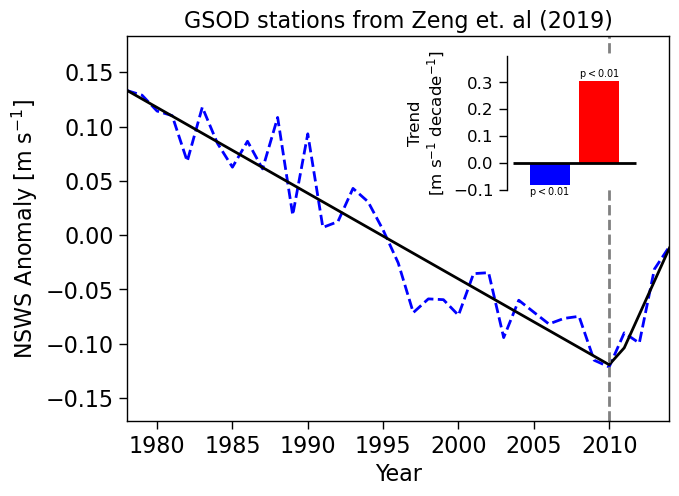

,source,break_year,slope_1,slope_2,p_val_1,p_val_2,sig_1,sig_2
0,GSOD,2010,-0.078974,0.306634,6.859564e-19,5.497378e-07,True,True


In [59]:
obs_path = 'data/Zeng-2019/41558_2019_622_MOESM2_ESM.xlsx'
# GSOD data from Zeng (2019) -> not using HADISD
excel = pd.ExcelFile(obs_path)
# See sheet names
stations = excel.parse('stations')
obs_lats = stations['lats']
obs_lons = stations['lons']  # don't want negative degrees
station_nums = stations['stations']
obs_winds = excel.parse('winds')

gsod = xr.Dataset(
            data_vars={
                'GSOD': (["station", "year"], obs_winds.to_numpy()[:, 1:-3])
            },
            coords={
                'station': station_nums,
                'year': pd.date_range(start='1978', end='2015', freq='Y'), # [1978, 2014]
                'lon': ("station", obs_lons),
                'lat': ("station", obs_lons)
            }
    )
# Get yearly data
anom = gsod.GSOD - gsod.GSOD.mean('year')
obs_anom = anom.groupby('year').mean('station') # means
# obs_q = anom.groupby('year').quantile([0.25, 0.75], dim='station') # quantiles
# Construct years out of numpy datetime to use for regression
years = np.arange(1978, 2015)

# Compute gsod piecewise linear fit
gsod_pwlf = pwlf.PiecewiseLinFit(years, obs_anom)
breaks = gsod_pwlf.fit(2)
break_year = int(breaks[1])
slopes = gsod_pwlf.calc_slopes()*10
p_vals = gsod_pwlf.p_values()[1:]  # betas are [intercept, slope1, slope2, ...]
# print(f'Piecewise Parameters\n\tBreakpoint: {break_year}\n\tDecadal Slopes: {slopes}\n\tP-Values: {p_vals}')
y_hat = gsod_pwlf.predict(years)

# Make plot
fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
ax_min = min(obs_anom) - 0.05
ax_max = max(obs_anom) + 0.05
ax.plot(years, obs_anom, linestyle='--', color='blue')
ax.plot(years, y_hat, '-', color='k')
ax.vlines(break_year, ax_min, ax_max, color='gray', linestyle='--')
ax.set_ylim(ax_min, ax_max)
ax.set_xlim(1978, 2014)
# ax.fill_between(years, obs_q.isel(quantile=0), obs_q.isel(quantile=1), color='red', alpha=0.1)
# Add small annotation
ins = ax.inset_axes([0.7, 0.6, 0.25, 0.35])
pos = slopes > 0
neg = slopes < 0
l = np.array([1, 2])
for i, (m, p) in enumerate(zip(slopes, p_vals)):
    i+=1
    if m > 0:
        rects = ins.bar(i, m, color='red')
    else:
        rects = ins.bar(i, m, color='blue')
    if p < 0.01:
        ins.bar_label(rects, ['p$<$0.01'])
# Partition the percentile values to be able to draw large numbers in
# white within the bar, and small numbers in black outside the bar.
ins.hlines(0, 0.25, 2.75, color='k')
# Remove spines
ins.spines['top'].set_visible(False)
ins.spines['right'].set_visible(False)
ins.spines['bottom'].set_visible(False)
# Remove ticks
ins.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
)
# Set ticks
ymin = int(min(slopes)/0.1)*0.1-0.1
ymax = int(max(slopes)/0.1)*0.1+0.1
ins.set_yticks(np.arange(ymin, ymax, 0.1))
ins.tick_params(axis='y', labelsize=12)
ins.set_ylim(ymin, ymax)
ins.set_ylabel('Trend\n[m s$^{-1}$ decade$^{-1}$]', fontsize=12)

# Labels
ax.set_xlabel('Year')
ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
ax.set_title('GSOD stations from Zeng et. al (2019)')
plt.show()

# Save data to dataframe
piecewise_params = pd.DataFrame(
    dict(
        source='GSOD',
        break_year=break_year,
        slope_1=slopes[0],
        slope_2=slopes[1],
        p_val_1=p_vals[0],
        p_val_2=p_vals[1],
        sig_1=p_vals[0] < 0.01,
        sig_2=p_vals[1] < 0.01,
    ), index=[0]
)
piecewise_params

## Plots Average Land Trend

Plotting models:   0%|          | 0/14 [00:00<?, ?it/s]

Plotting models:   0%|          | 0/14 [00:01<?, ?it/s]


Parameters of piecewise regression:

source  break_year   slope_1   slope_2       p_val_1       p_val_2  \
0          GSOD        2010 -0.078970  0.306968  6.854771e-19  5.497403e-07   
1  IPSL-CM6A-LR        1997 -0.027285 -0.010207  9.339894e-05  1.865114e-01   

   sig_1  sig_2  
0   True   True  
1   True  False

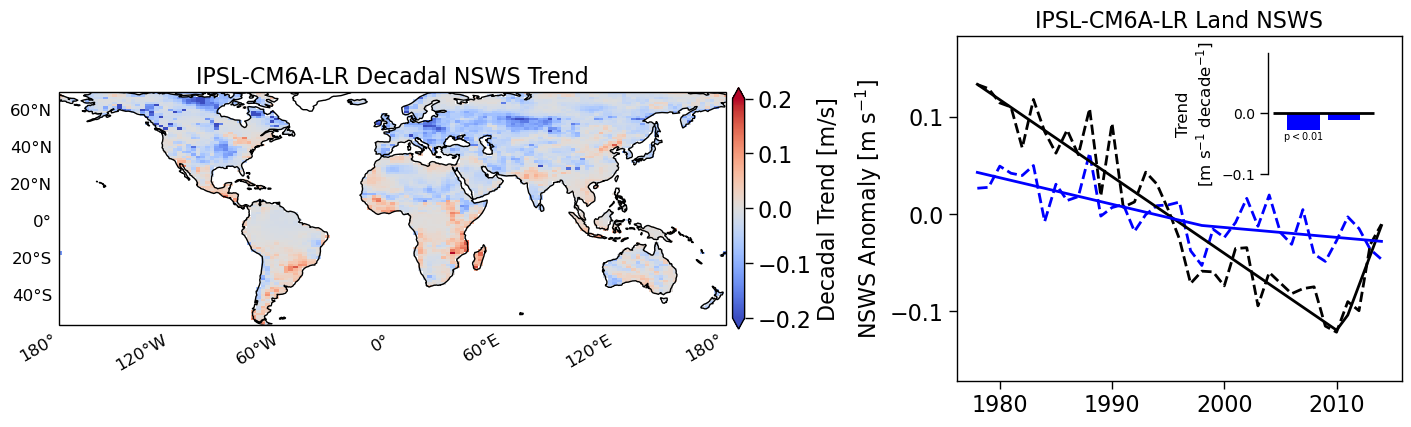

In [56]:
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110



fig = plt.figure(figsize=(14, int(n_models*3.5)), constrained_layout=True)
gs = fig.add_gridspec(n_models, 2, width_ratios=[1.5, 1])

for i, model in enumerate(tqdm(ensemble.keys(), desc='Plotting models')):
    ds = ensemble[model]
    # Get anomaly
    ds = ds - ds.cf.mean('T')
    # mask to land
    land = mask_data(ds, land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # land = land.where(land,drop=True)
    # Create axes for plotting
    map = fig.add_subplot(gs[i, 0], projection=ccrs.PlateCarree())
    ts = fig.add_subplot(gs[i, 1])
    # Plot map
    trend = (
        land['sfcWind'].cf.groupby('T.year').mean()
        .polyfit('year', deg=1, skipna=True)
        .polyfit_coefficients.sel(degree=1)*10  # decadal
    )
    im = trend.plot(ax=map, vmin=-0.2, vmax=0.2, cmap='coolwarm', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.set_label(label='Decadal Trend [m/s]')
    # Plot time series
    land_nsws = land['sfcWind'].cf.groupby('T.year').mean().cf.mean(['X', 'Y']).values
    ts.plot(years, land_nsws, label=model, color='blue', linestyle='--')
    ts.plot(years, obs_anom, label='GSOD', color='k', linestyle='--')
    ts.plot(years, gsod_pwlf.predict(years), color='k')
    # Add model linear fit
    model_pwlf = pwlf.PiecewiseLinFit(years, land_nsws)
    breaks = model_pwlf.fit(2)
    break_year = int(breaks[1])
    slopes = model_pwlf.calc_slopes()*10  # make decadal
    p_vals = model_pwlf.p_values()[1:]  # betas are [intercept, slope1, slope2, ...]
    # print(f'Piecewise Parameters\n\tBreakpoint: {break_year}\n\tDecadal Slopes: {slopes}\n\tP-Values: {p_vals}')
    ts.plot(years, model_pwlf.predict(years), color='blue')
    ax_min = min(min(obs_anom), min(land_nsws)) - 0.05
    ax_max = max(max(obs_anom), max(land_nsws)) + 0.05
    ax.vlines(break_year, ax_min, ax_max, color='gray', linestyle='--')
    ts.set_ylim(ax_min, ax_max)
    # Annotation plot for trend
    ins = ts.inset_axes([0.7, 0.6, 0.25, 0.35])
    pos = slopes > 0
    neg = slopes < 0
    l = np.array([1, 2])
    for i, (m, p) in enumerate(zip(slopes, p_vals)):
        i+=1
        if m > 0:
            rects = ins.bar(i, m, color='red')
        else:
            rects = ins.bar(i, m, color='blue')
        if p < 0.01:
            ins.bar_label(rects, ['p$<$0.01'])
    # Partition the percentile values to be able to draw large numbers in
    # white within the bar, and small numbers in black outside the bar.
    ins.hlines(0, 0.25, 2.75, color='k')
    # Remove spines
    ins.spines['top'].set_visible(False)
    ins.spines['right'].set_visible(False)
    ins.spines['bottom'].set_visible(False)
    # Remove ticks
    ins.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
    )
    # Set ticks
    ymin = int(min(slopes)/0.1)*0.1-0.1
    ymax = int(max(slopes)/0.1)*0.1+0.1
    ins.set_yticks(np.arange(ymin, ymax, 0.1))
    ins.tick_params(axis='y', labelsize=10)
    ins.set_ylim(ymin, ymax)
    ins.set_ylabel('Trend\n[m s$^{-1}$ decade$^{-1}$]', fontsize=12)
    
    
    # Map options
    map.add_feature(cfeature.COASTLINE)
    # map.add_feature(cfeature.BORDERS)
    map.set_title(f'{model} Decadal NSWS Trend')
    gl = map.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 12, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 12, 'color': 'k', 'weight': 'normal'}

    # Time series options
    ts.set_title(f'{model} Land NSWS')
    ts.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # Save results of piecewise fit
    piecewise_params = pd.concat([
        piecewise_params, 
        pd.DataFrame(
            dict(
                source=model,
                break_year=break_year,
                slope_1=slopes[0],
                slope_2=slopes[1],
                p_val_1=p_vals[0],
                p_val_2=p_vals[1],
                sig_1=p_vals[0] < 0.01,
                sig_2=p_vals[1] < 0.01
                ), index=[0]
        )
        ], ignore_index=True)

plt.savefig('figures/amip-hist-land-trends.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
print('Parameters of piecewise regression:')
print(piecewise_params)
plt.show()

## Heatmap of prediction
